<a href="https://colab.research.google.com/github/robertoricci/Analise-Financeira/blob/main/Extrai_Dividendos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas_datareader -U

In [12]:
# Imports
from bs4 import BeautifulSoup
import pandas as pd
from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go

from datetime import datetime

from pandas_datareader import data as web

In [13]:
def dividendos_acao(acao: str):
    # Definindo características da página
    url = f'https://fundamentus.com.br/proventos.php?papel={acao}&tipo=2'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.100 Safari/537.36'}

    # Fazendo a request
    try:
        req = Request(url, headers = headers)
        response = urlopen(req)
        html = response.read()

    # Tratando alguns possíveis erros
    except HTTPError as e:
        print('HTTPError\n\n')

    except URLError as e:
        print('URLError\n\n')

    # Instanciando um objeto BeautifulSoup
    soup = BeautifulSoup(html, 'html.parser')

    # Pegando os nomes das colunas da tabela
    colunas_names = [col.getText() for col in soup.find('table', {'id': 'resultado'}).find('thead').findAll('th')]
    colunas = {i: col.getText() for i, col in enumerate(soup.find('table', {'id': 'resultado'}).find('thead').findAll('th'))}

    # Criando um DataFrame com os nomes das colunas
    dados = pd.DataFrame(columns=colunas_names)

    # Pegando os dados da tabela por linha
    for i in range(len(soup.find('table', {'id': 'resultado'}).find('tbody').findAll('tr'))):
        linha = soup.find('table', {'id': 'resultado'}).find('tbody').findAll('tr')[i].getText().split('\n')[1:]
        inserir_linha = pd.DataFrame(linha).T.rename(columns=colunas)
        dados = pd.concat([dados, inserir_linha], ignore_index=True)
        dados['date'] = dados.Data.map(lambda x: x.split()[0])
        dados['date'] = pd.to_datetime(dados.date)
        dados['valor'] = dados.Data.map(lambda x: x.split()[1])
        dados['valor'] = dados.valor.map(lambda x: float(x.replace(',', '.')))

    # Rearranjando o df
    dados = dados.drop(columns=['Data'])
    dados['tipo'] = dados.Valor
    dados = dados.drop(columns=['Valor'])
    dados['data_pagamento'] = dados.Tipo
    dados = dados.drop(columns=['Tipo', 'Data de Pagamento', 'Por quantas ações'])

    #
    return dados

In [14]:
dividendos_acao('PETR3')

,date,valor,tipo,data_pagamento
0,2022-11-21,1.6002,DIVIDENDO,19/01/2023
1,2022-11-21,1.1558,DIVIDENDO,20/12/2022
2,2022-11-21,0.5186,JRS CAP PROPRIO,20/12/2022
3,2022-11-21,0.0743,JRS CAP PROPRIO,19/01/2023
4,2022-11-08,3.3660,DIVIDENDO,20/09/2022
...,...,...,...,...
77,1998-03-24,0.1941,DIVIDENDO,-
78,1998-03-24,0.0594,DIVIDENDO,-
79,1997-03-21,0.4996,DIVIDENDO,-
80,1997-03-21,0.4700,DIVIDENDO,-


In [15]:
def stonk_last_value(acao: str, start_date: str = None):
    if start_date == None:
        start_date = '01-01-2000'    
    # importar dados para o DataFrame
    return web.DataReader(f'{acao}.SA', data_source='yahoo', start=start_date)

In [16]:
def dividendos_fii(fii: str):
    # Definindo características da página
    url = f'https://fundamentus.com.br/fii_proventos.php?papel={fii}&tipo=2'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.100 Safari/537.36'}

    # Fazendo a request
    try:
        req = Request(url, headers = headers)
        response = urlopen(req)
        html = response.read()

    # Tratando alguns possíveis erros
    except HTTPError as e:
        print('HTTPError\n\n')

    except URLError as e:
        print('URLError\n\n')

    # Instanciando um objeto BeautifulSoup
    soup = BeautifulSoup(html, 'html.parser')

    # Pegando os nomes das colunas da tabela
    colunas_names = [col.getText() for col in soup.find('table', {'id': 'resultado'}).find('thead').findAll('th')]
    colunas = {i: col.getText() for i, col in enumerate(soup.find('table', {'id': 'resultado'}).find('thead').findAll('th'))}

    # Criando um DataFrame com os nomes das colunas
    dados = pd.DataFrame(columns=colunas_names)

    # Pegando os dados da tabela por linha
    for i in range(len(soup.find('table', {'id': 'resultado'}).find('tbody').findAll('tr'))):
        linha = soup.find('table', {'id': 'resultado'}).find('tbody').findAll('tr')[i].getText().split('\n')[1:-1]
        inserir_linha = pd.DataFrame(linha).T.rename(columns=colunas)
        dados = pd.concat([dados, inserir_linha], ignore_index=True)
        dados['date'] = pd.to_datetime(dados['Última Data Com'])
        dados['valor'] = dados.Valor.map(lambda x: float(x.replace(',', '.')))        

    dados['tipo'] = dados['Tipo']
    dados['data_pagamento'] = dados['Data de Pagamento']
    dados = dados.drop(columns=['Tipo', 'Última Data Com', 'Valor', 'Data de Pagamento'])

    #
    return dados

In [17]:
def plot_by_dividendo(codigo_ativo: str, kind: str):
    if kind == 'fii':
        df = dividendos_fii(codigo_ativo)
    elif kind == 'acao':
        df = dividendos_acao(codigo_ativo)
    else:
        raise ValueError (f'Os valores aceitáveis são: fii e acao')
    # Gerando grafico para a acao
    fig, ax = plt.subplots(figsize=(25,8))
    conv_date = df.date.sort_values().map(lambda x: x.strftime('%d-%m-%Y'))
    fig = sns.barplot(x=conv_date, y=df.valor, data=df)
    title = f'{codigo_ativo} - dividendo/mes'
    fig.set_title(title.upper(), fontsize=25)
    plt.grid()
    plt.xticks(rotation=90)
    fig = fig

In [18]:
def plot_by_year(codigo_ativo: str, kind: str):
    if kind == 'fii':
        df = dividendos_fii(codigo_ativo)
    elif kind == 'acao':
        df = dividendos_acao(codigo_ativo)
    else:
        raise ValueError (f'Os valores aceitáveis são: fii e acao')
    # Gerando grafico para a acao
    fig, ax = plt.subplots(figsize=(25,8))
    fig = sns.barplot(x=df.date.map(lambda x: x.year), y=df.valor, data=df)
    title = f'{codigo_ativo} - dividendo/ano'
    fig.set_title(title.upper(), fontsize=25)
    plt.grid()
    plt.xticks(rotation=90)
    fig = fig

In [19]:
def my_acao(plot = None):
    # Acoes da minha carteira
    acoes: list = [
        'taee4',
        'enbr3',
        'csmg3',
        'itsa4',
        'enat3',
        'cmig4',
        'bbse3',
        'trpl4',
        'vale3',
        'wege3',
    ]
    # Criando listas para armazenar os valores
    median_list: list = []
    last_value_list: list = []
    magic_number_list: list = []
    price_magic_number_list: list = []

    for acao in acoes: 
        # Ultima valor de fechamento da acao
        stonk_value: float = round(stonk_last_value(acao, '01-01-2015').iloc[-1].Close, 2)
        last_value_list.append(stonk_value)

        # Media dos dividendos por mes
        df = dividendos_acao(acao).query('date > 2015')
        median_by_year = df.groupby(df.date.map(lambda x: x.year)).median()
        median_by_month_value = float(median_by_year.median()[0] / 12)
        median_list.append(median_by_month_value)

        # magic_number: valor_acao / dividendo_mes
        magic_number_value: int = int(stonk_value / median_by_month_value)
        magic_number_list.append(magic_number_value)

        # Valor para o MG
        price_magic_number: float = round(stonk_value * magic_number_value, 2)
        price_magic_number_list.append(price_magic_number)

        # Plots
        if plot:
            plot_by_dividendo(acao, 'acao')
            plot_by_year(acao, 'acao')

    # Criando o df
    df_acoes = pd.DataFrame(acoes, columns=['code'])
    df_acoes['last_value'] = pd.DataFrame(last_value_list)
    df_acoes['median'] = pd.to_numeric(median_list)
    df_acoes['magic_number'] = pd.to_numeric(magic_number_list)
    df_acoes['price_magic_number'] = pd.to_numeric(price_magic_number_list)

    return df_acoes

In [20]:
def my_fii(plot = None):
    # FIIs da minha carteira
    fiis: list = [
        'alzr11',
        'bcff11',
        'hglg11',
        'xplg11',
        'xpin11',
        'mxrf11',
        'hfof11',
        'rect11',
        'hctr11',
        'knip11',
        'irdm11',
        'vino11',
    ]
     # Criando listas para armazenar os valores
    median_fii_list: list = []
    last_fii_value_list: list = []
    last_fii_div_list: list = []
    value_div_fii_list: list = []
    magic_number_fii_list: list = []
    price_magic_number_fii_list: list = []

    for fii in fiis:
        # Ultima valor de fechamento da acao
        stonk_value: float = round(stonk_last_value(fii, '01-01-2015').iloc[-1].Close, 2)
        last_fii_value_list.append(stonk_value)

        df = dividendos_fii(fii).query('date > 2015')

        # Ultimo dividendo
        last_div = dividendos_fii(fii).query('date > 2015').valor.iloc[0]
        last_fii_div_list.append(last_div)

        # Mediana dos dividendos por mes
        median_by_year = df.groupby(df.date.map(lambda x: x.year)).median()
        median_by_month_value: float = float(median_by_year.median())
        median_fii_list.append(median_by_month_value)

        # value_div: las_value / last_div
        value_div: float = (last_div / stonk_value) * 100
        value_div_fii_list.append(value_div)

        # magic_number: valor_acao / dividendo_mes
        magic_number_value = int(stonk_value / median_by_month_value)
        magic_number_fii_list.append(magic_number_value)

        # Valor para o MG
        price_magic_number: float = round(stonk_value * magic_number_value, 2)
        price_magic_number_fii_list.append(price_magic_number)

        # Plots
        if plot:
            plot_by_dividendo(fii, 'fii')
            plot_by_year(fii, 'fii')

    # Criando o df
    df_fiis = pd.DataFrame([fii.upper() for fii in fiis], columns=['code'])
    df_fiis['last_value'] = pd.DataFrame(last_fii_value_list)
    df_fiis['last_div'] = pd.DataFrame(last_fii_div_list)
    df_fiis['value_div'] = pd.DataFrame(value_div_fii_list)
    df_fiis['median_div'] = pd.to_numeric(median_fii_list)
    df_fiis['magic_number'] = pd.to_numeric(magic_number_fii_list)
    df_fiis['price_magic_number'] = pd.to_numeric(price_magic_number_fii_list)

    return df_fiis

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning

,code,last_value,last_div,value_div,median_div,magic_number,price_magic_number
0,ALZR11,114.91,0.78,0.678792,0.6400,179,20568.89
1,BCFF11,66.95,0.56,0.836445,0.5050,132,8837.40
2,HGLG11,165.28,1.10,0.665537,0.9400,175,28924.00
3,XPLG11,100.43,0.74,0.736832,0.6150,163,16370.09
4,XPIN11,74.95,0.64,0.853903,0.6200,120,8994.00
5,MXRF11,10.19,0.10,0.981354,0.0700,145,1477.55
6,HFOF11,71.29,0.62,0.869687,0.6000,118,8412.22
7,RECT11,55.35,0.50,0.903342,0.7050,78,4317.30
8,HCTR11,99.96,1.10,1.100440,1.4475,69,6897.24
9,KNIP11,91.80,0.30,0.326797,0.7500,122,11199.60


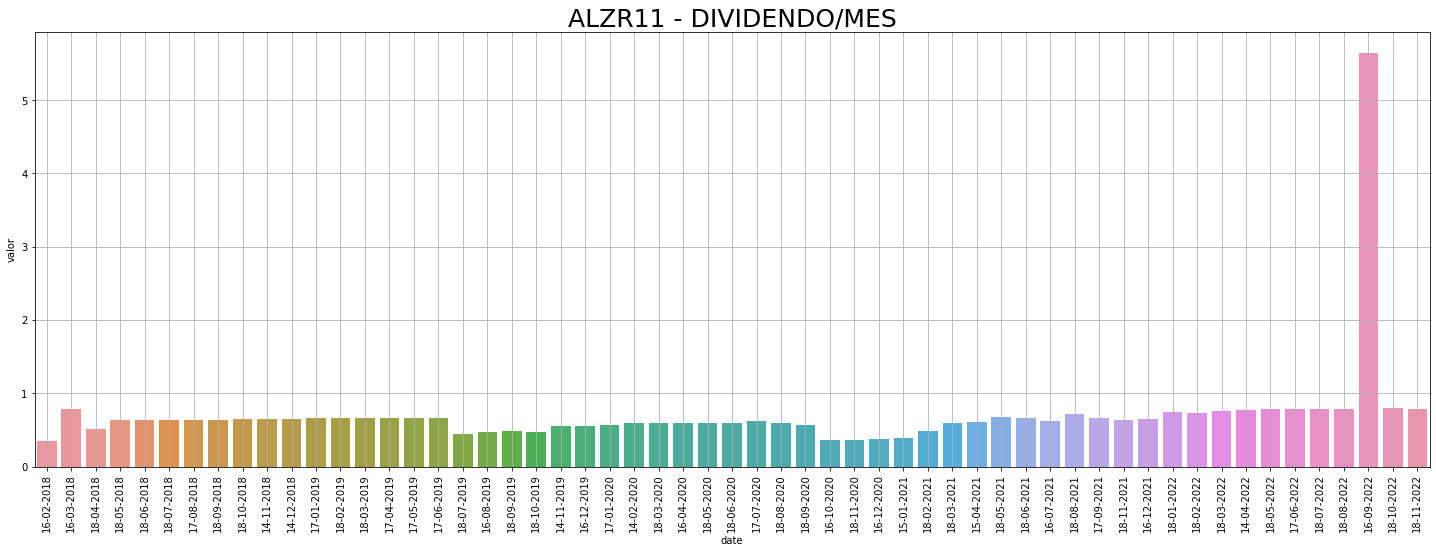

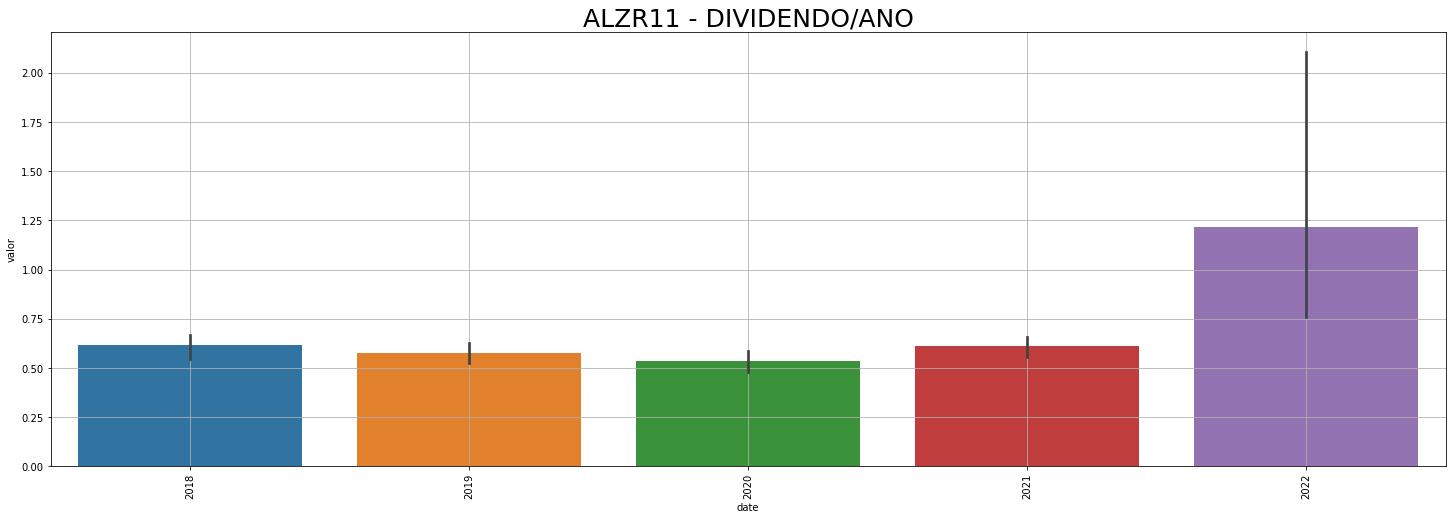

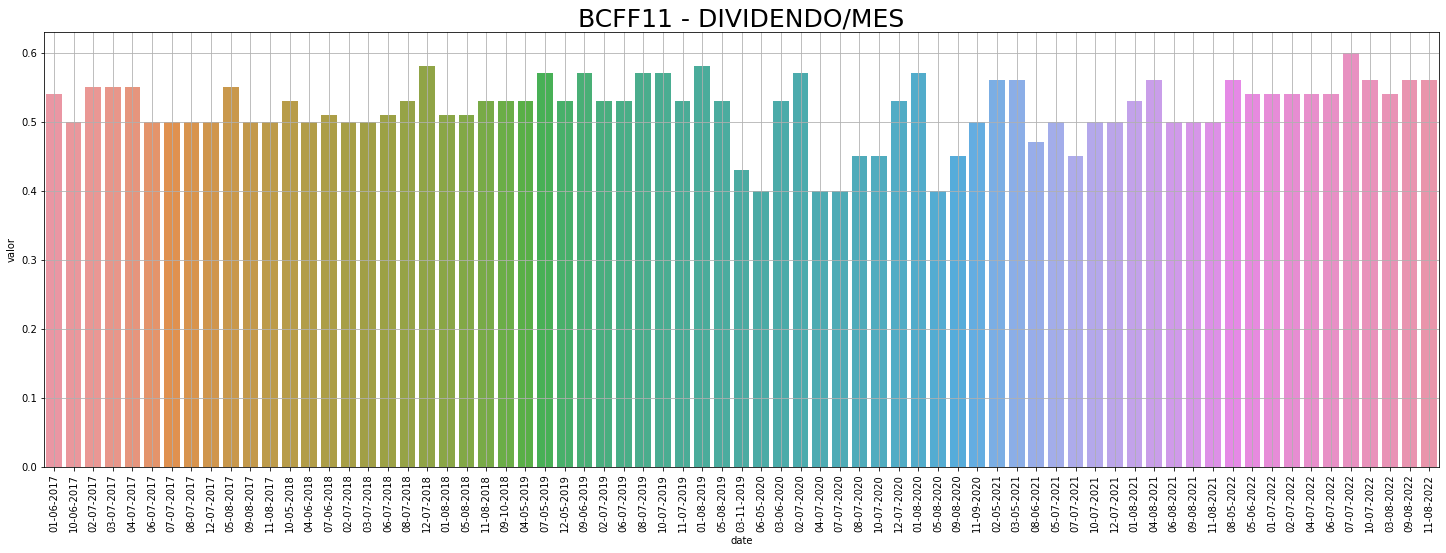

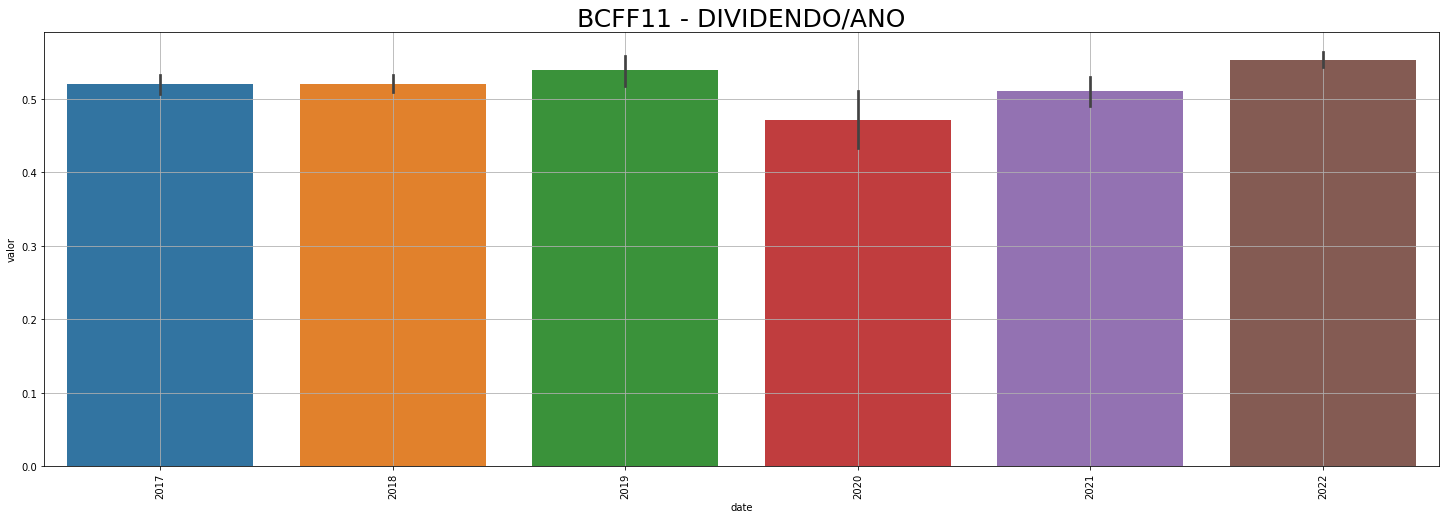

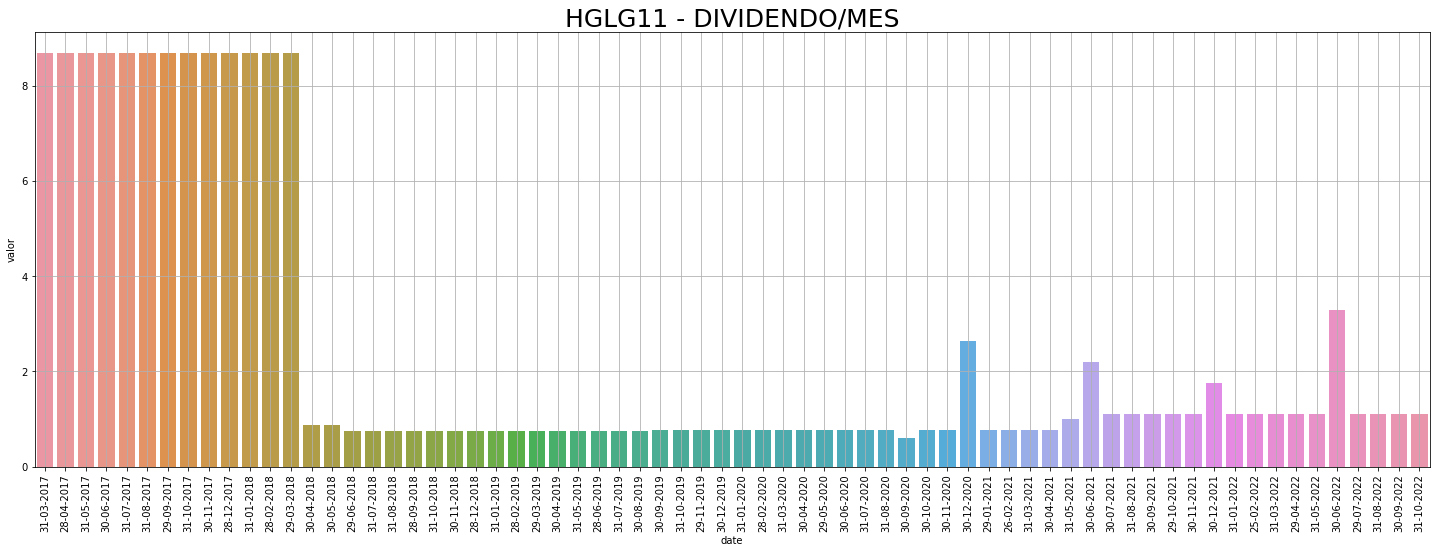

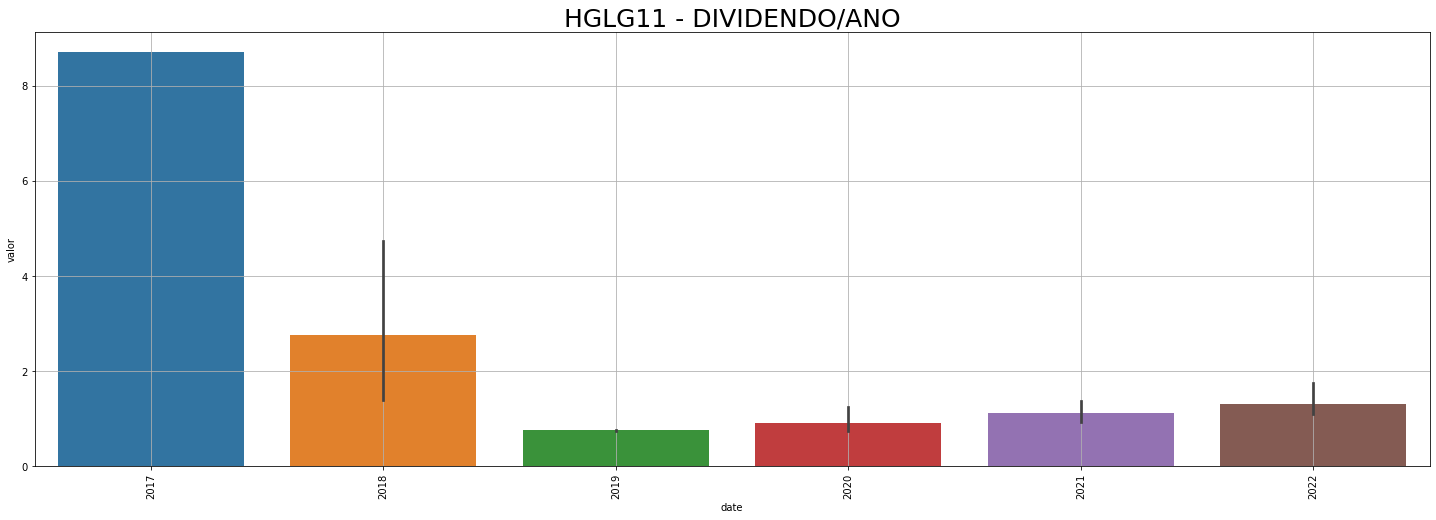

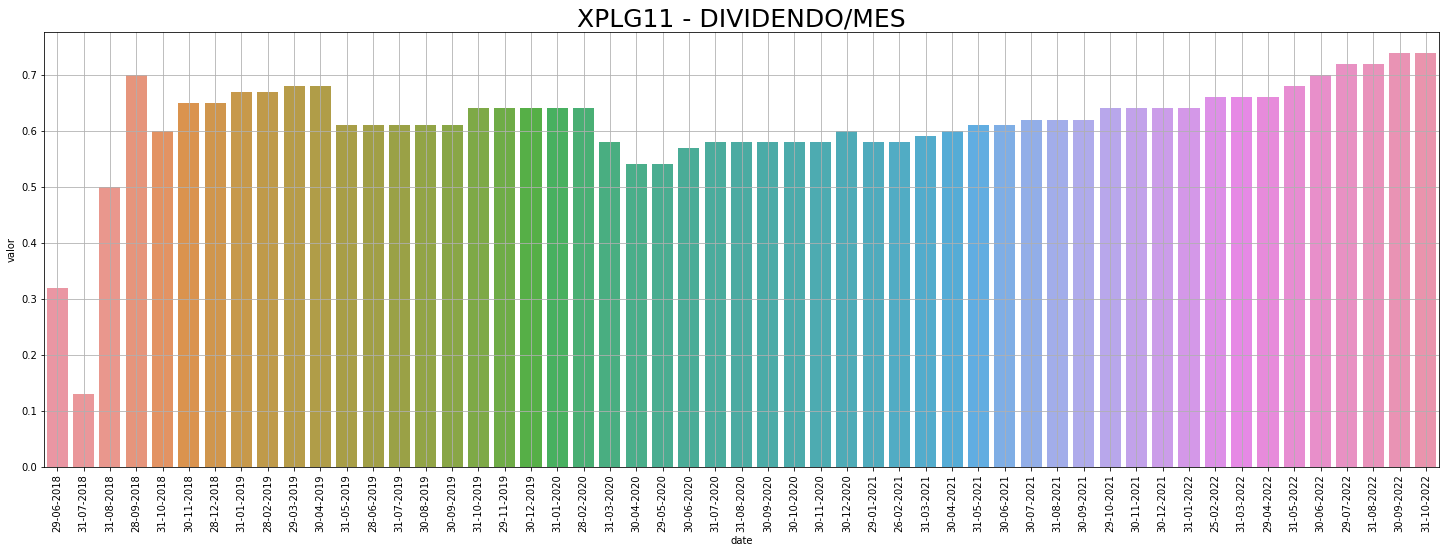

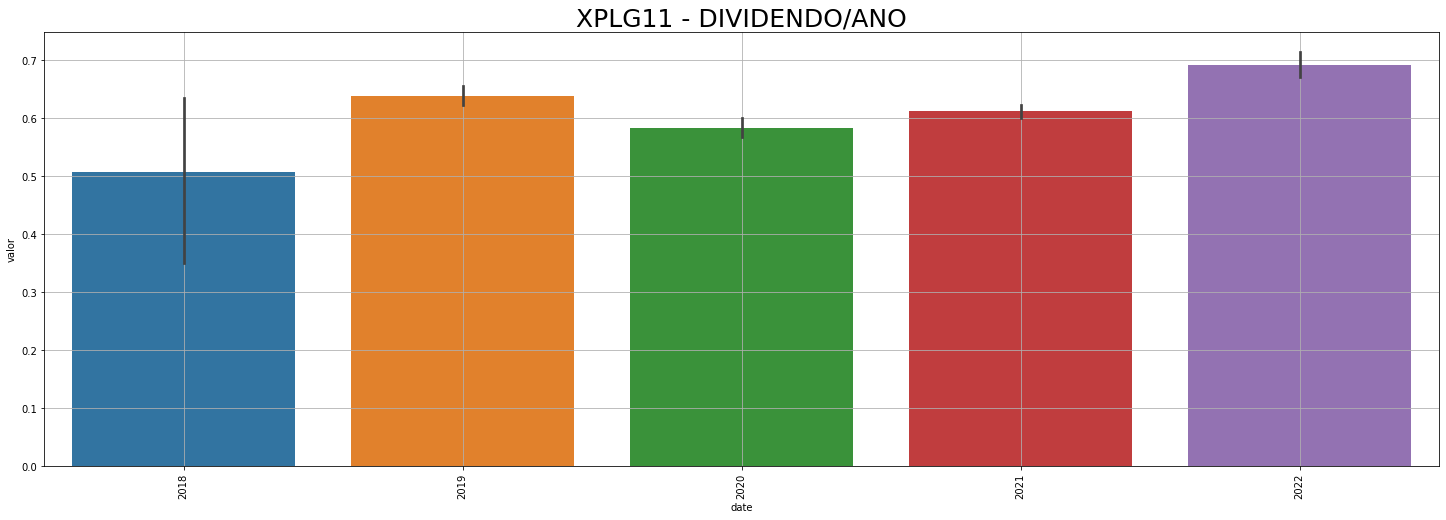

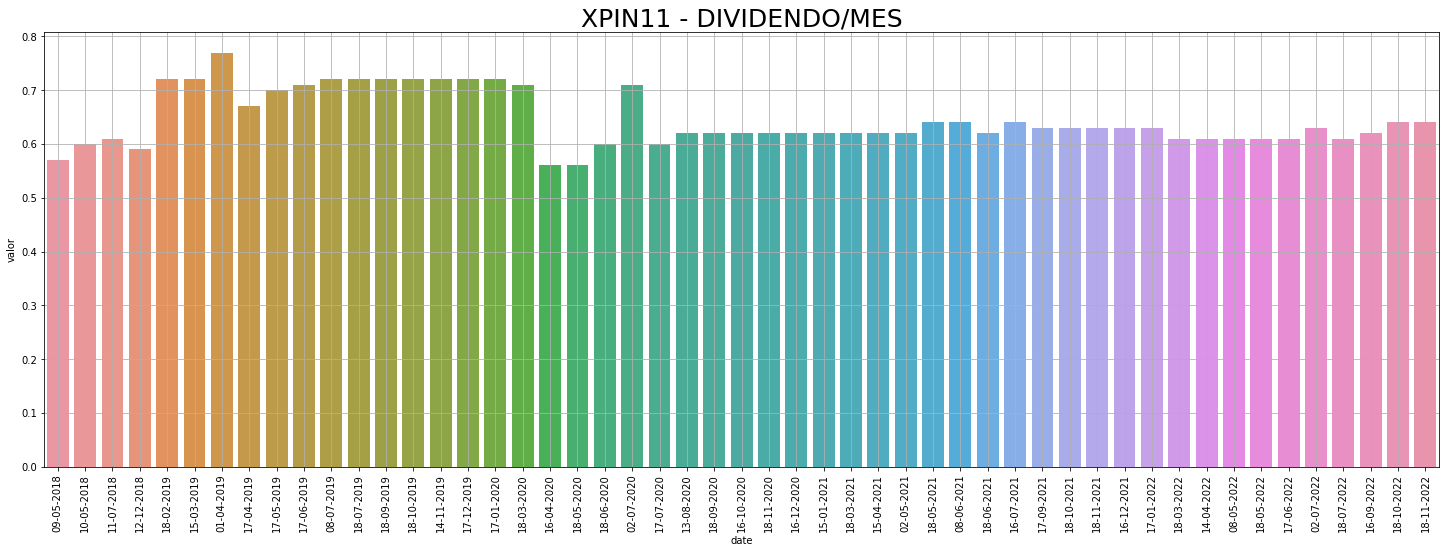

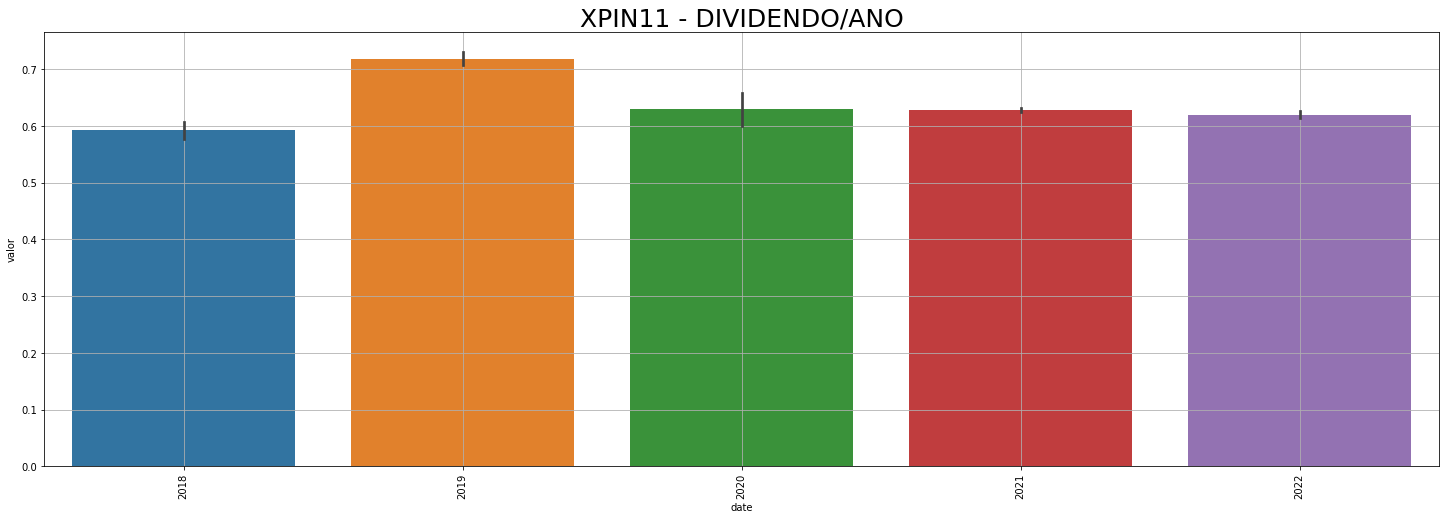

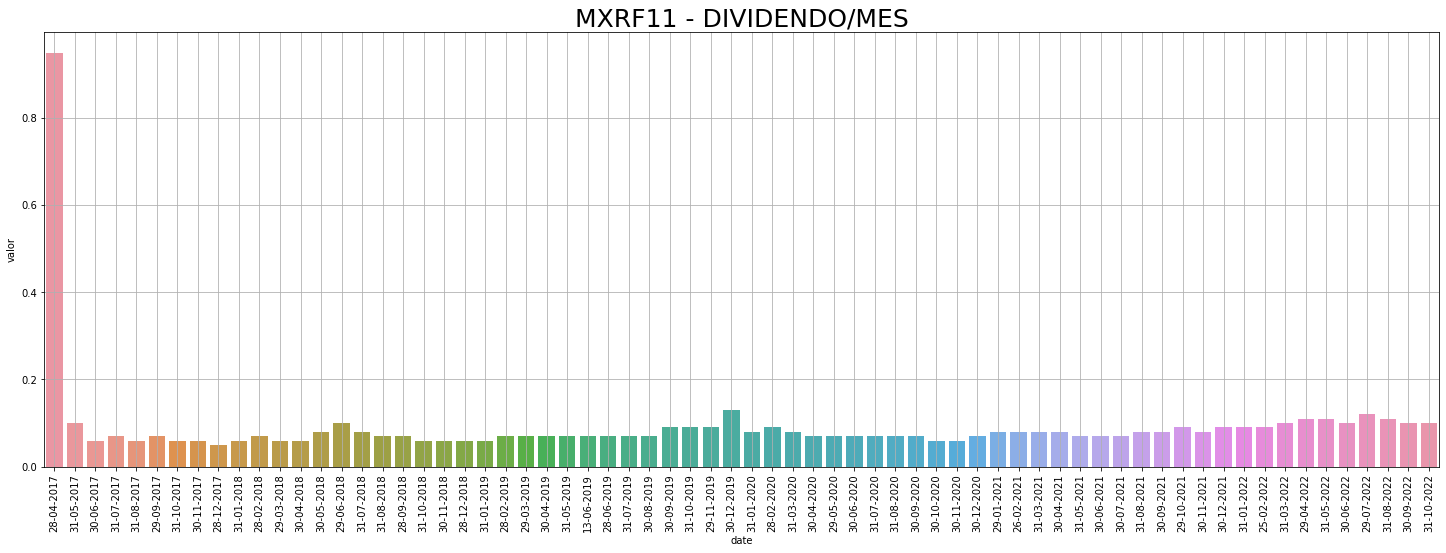

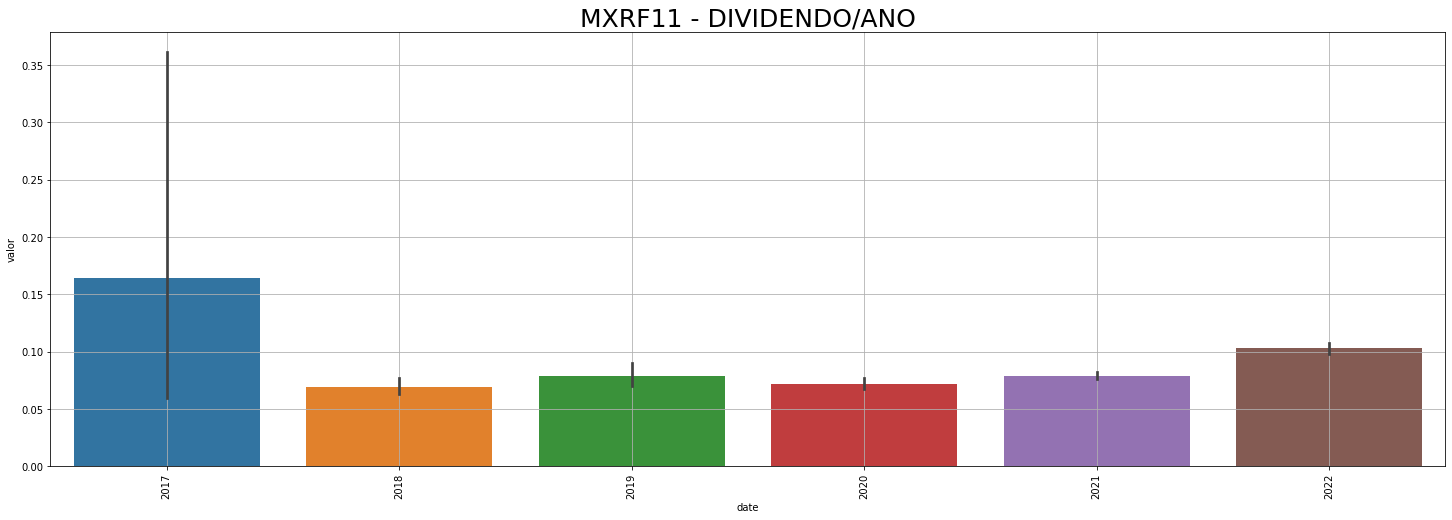

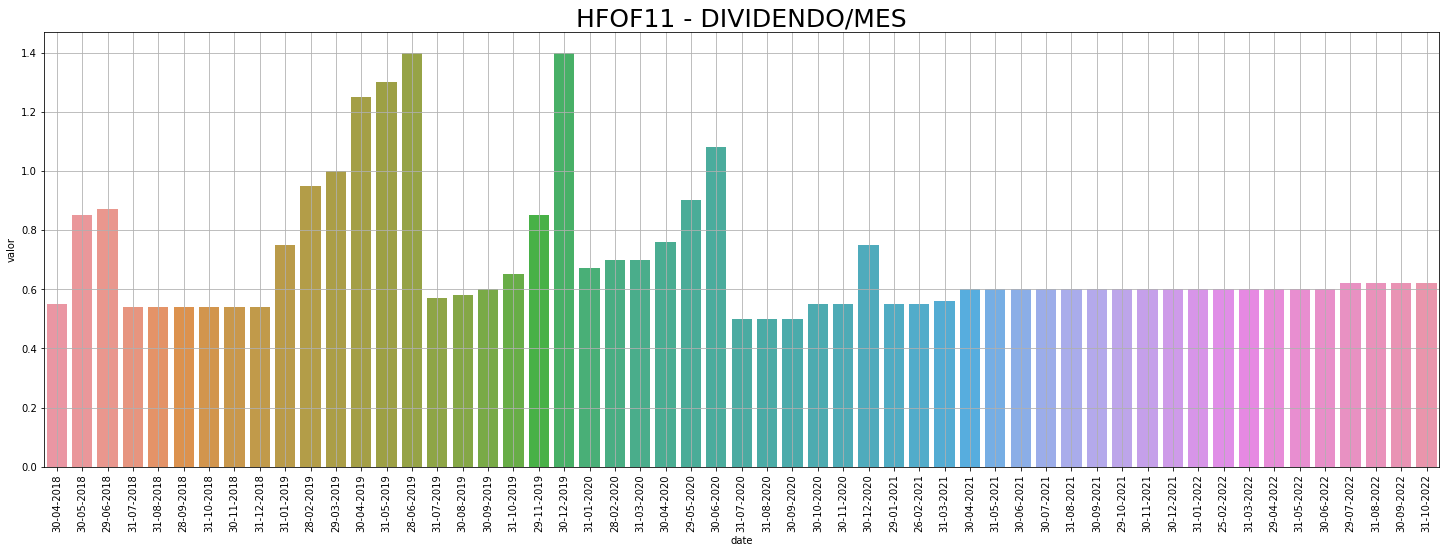

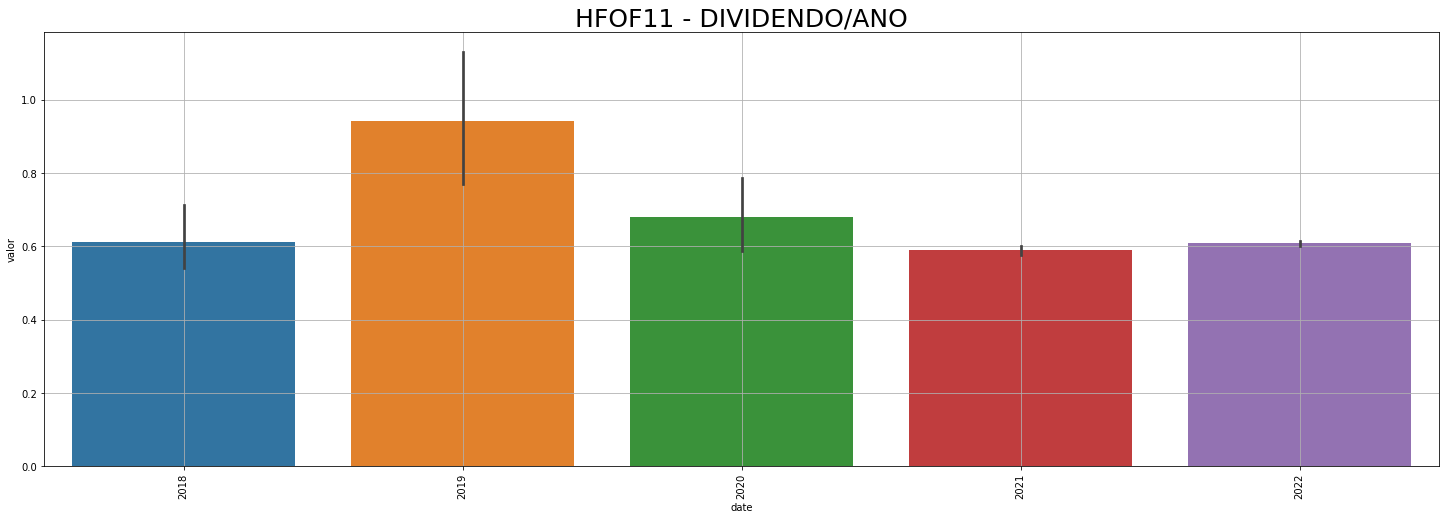

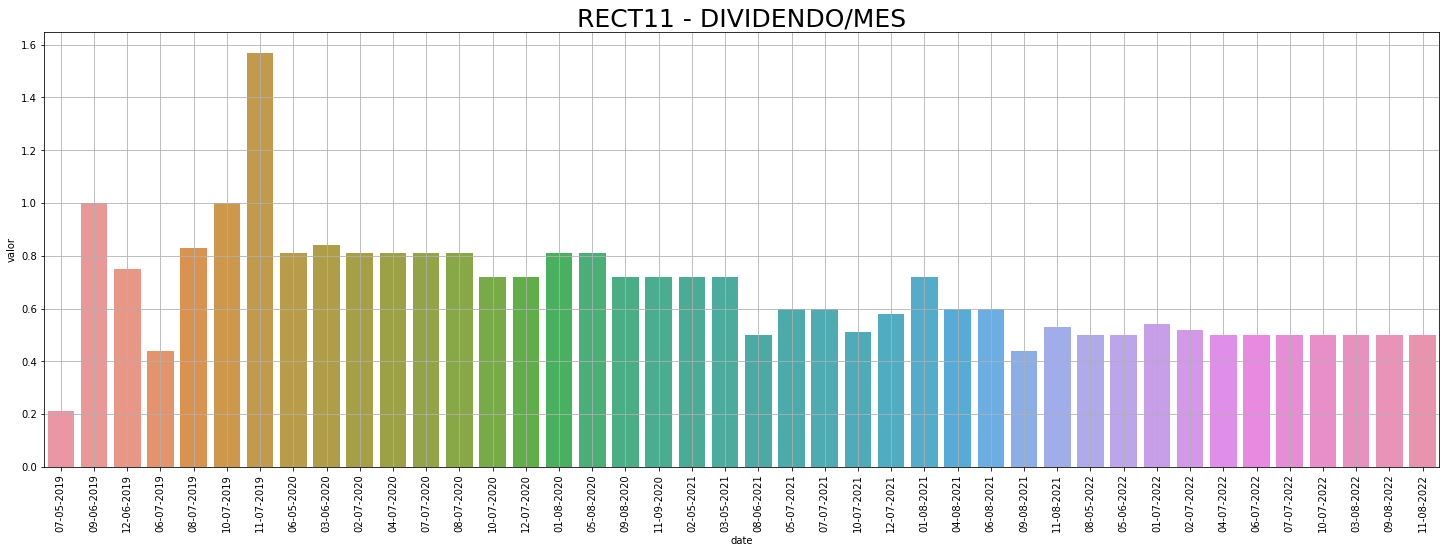

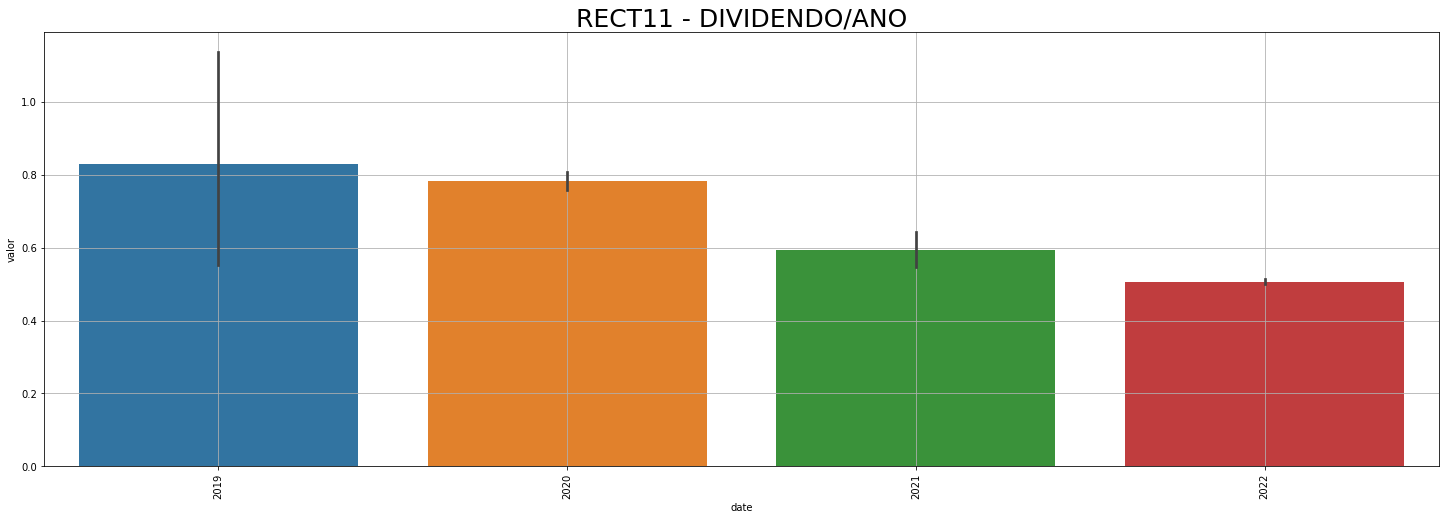

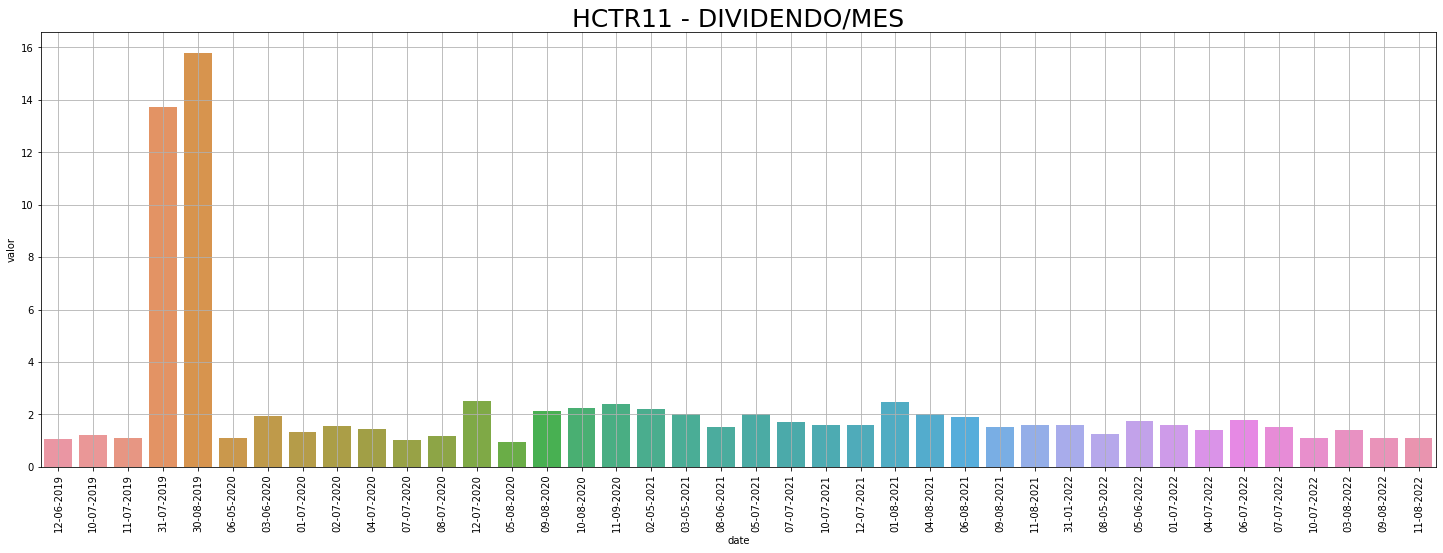

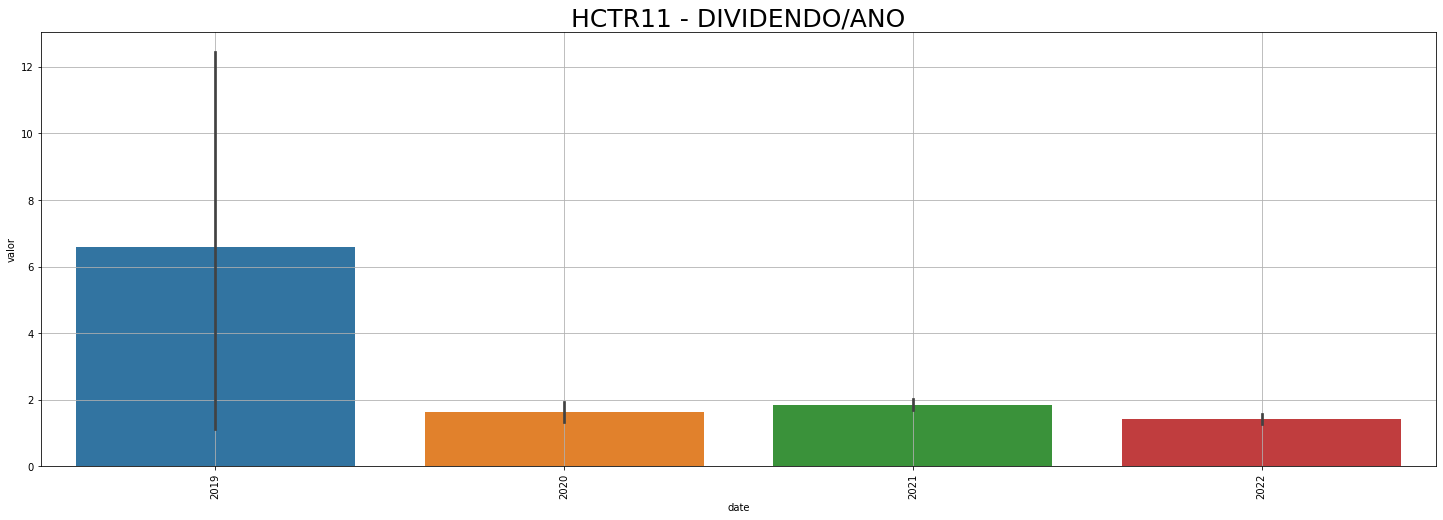

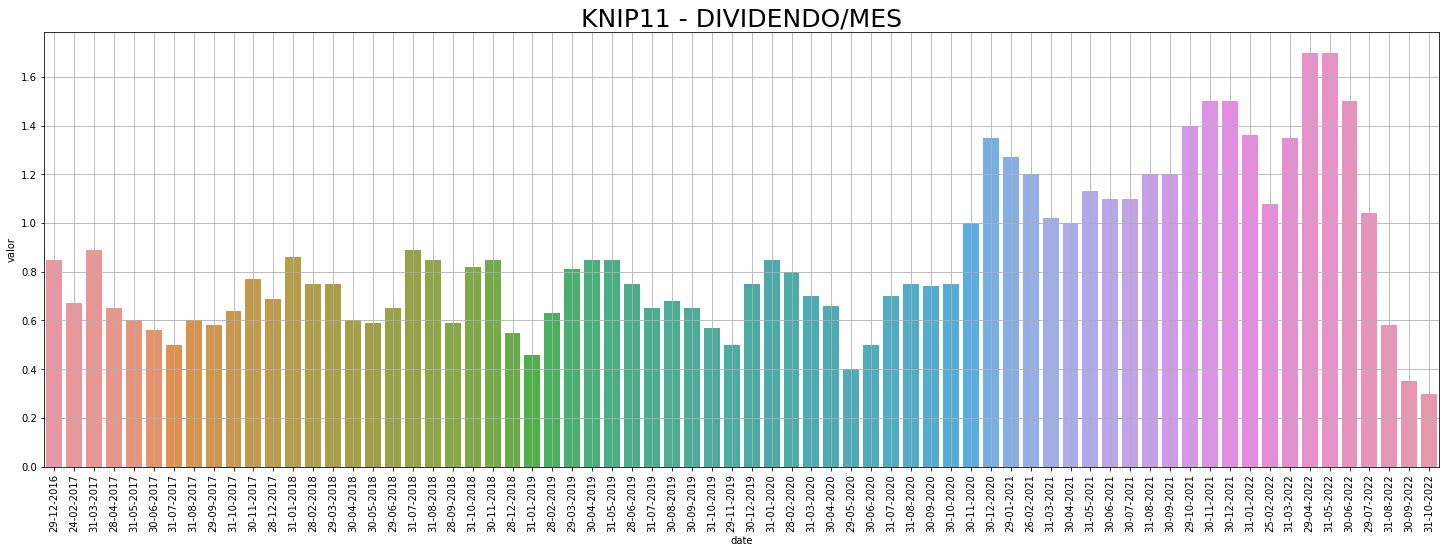

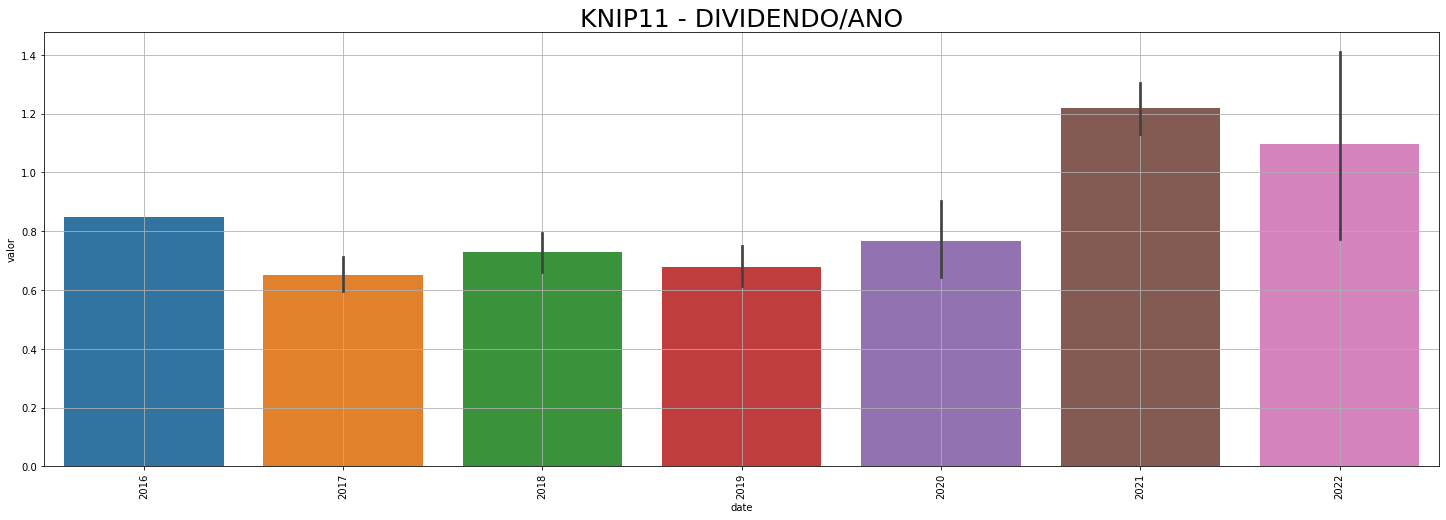

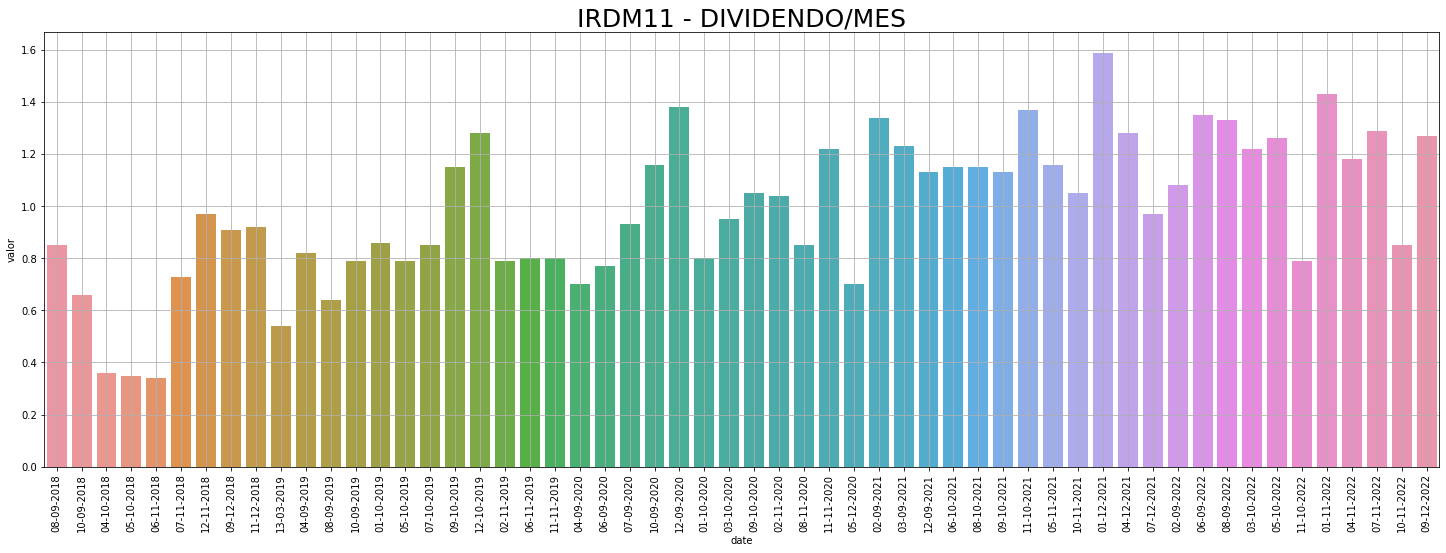

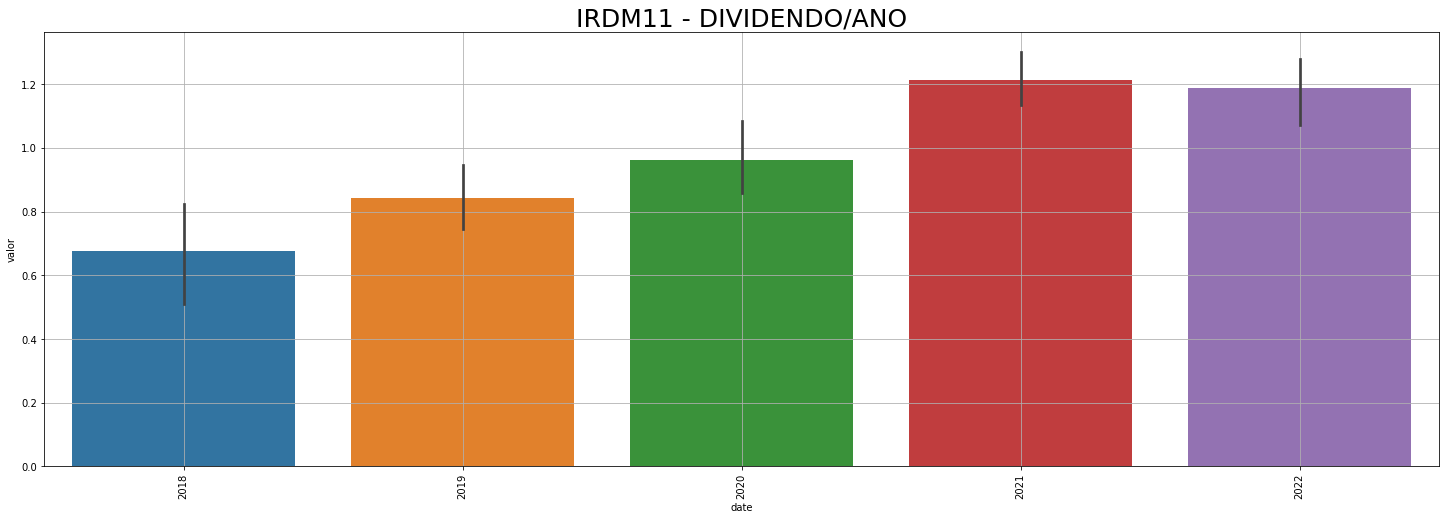

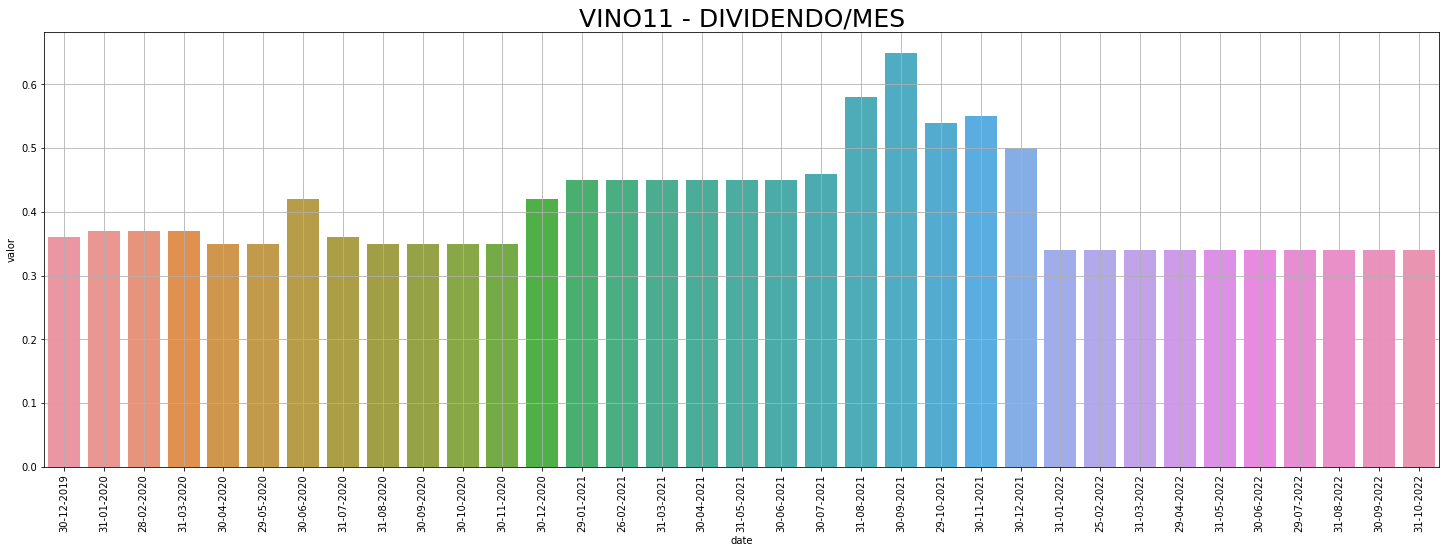

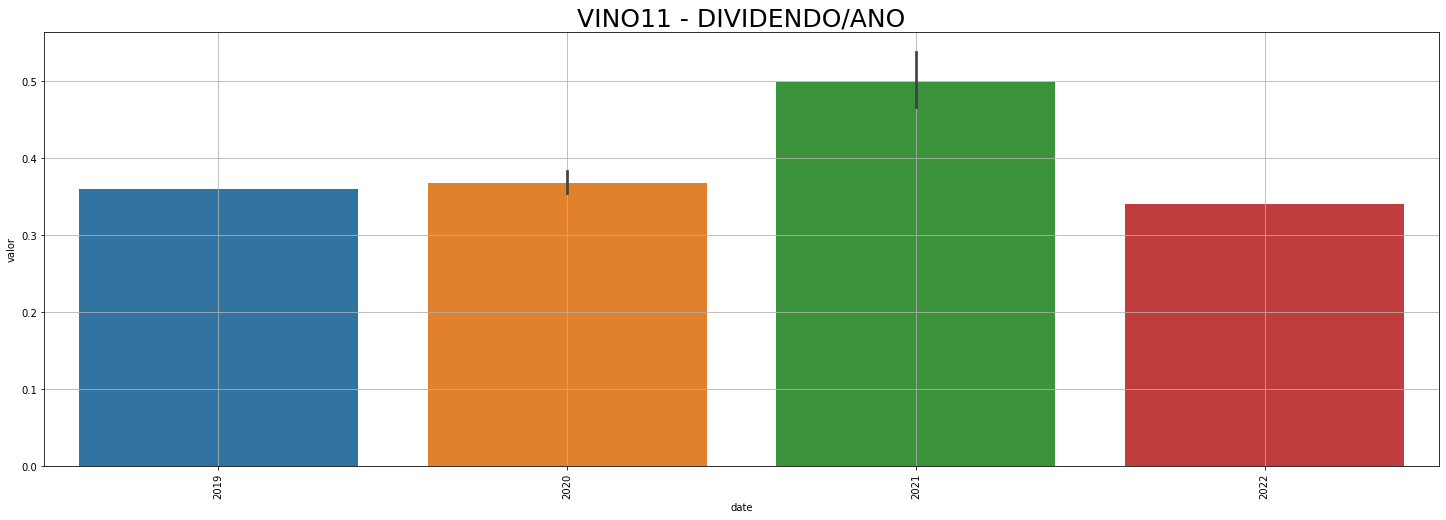

In [21]:
my_fii(plot=True)

In [22]:
my_fii().sort_values(by=['value_div'], ascending=False)

,code,last_value,last_div,value_div,median_div,magic_number,price_magic_number
8,HCTR11,99.97,1.10,1.100330,1.4475,69,6897.93
5,MXRF11,10.20,0.10,0.980392,0.0700,145,1479.00
7,RECT11,55.35,0.50,0.903342,0.7050,78,4317.30
6,HFOF11,71.29,0.62,0.869687,0.6000,118,8412.22
4,XPIN11,74.95,0.64,0.853903,0.6200,120,8994.00
1,BCFF11,66.98,0.56,0.836070,0.5050,132,8841.36
10,IRDM11,94.84,0.79,0.832982,0.9400,100,9484.00
3,XPLG11,100.44,0.74,0.736758,0.6150,163,16371.72
11,VINO11,47.45,0.34,0.716544,0.3575,132,6263.40
0,ALZR11,114.99,0.78,0.678320,0.6400,179,20583.21


In [23]:
df_sorted = dividendos_acao('bbse3').sort_values(by='date')
df_value = stonk_last_value('bbse3')

In [24]:
df_value

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-04-29,16.950001,16.100000,16.950001,16.600000,85582800.0,8.754207
2013-04-30,17.080000,16.600000,16.600000,17.049999,26950200.0,8.991518
2013-05-02,17.500000,16.980000,17.000000,17.500000,16057200.0,9.228834
2013-05-03,17.850000,17.370001,17.420000,17.750000,13031000.0,9.360674
2013-05-06,17.990000,17.639999,17.750000,17.930000,19911900.0,9.455597
...,...,...,...,...,...,...
2022-11-24,31.959999,30.900000,31.100000,31.709999,4297600.0,31.709999
2022-11-25,31.700001,30.650000,31.400000,30.700001,4881100.0,30.700001
2022-11-28,30.889999,30.340000,30.660000,30.549999,3960600.0,30.549999


In [25]:
data = [go.Scatter(
            x=df_sorted.date,
            y=df_sorted.valor
            )
        ]

layout = dict(
    autosize=False,
    width=1500,
    height=900,
)

fig = dict(data=data, layout=layout)
py.iplot(fig)

In [26]:
div = go.Scatter(
    x=df_sorted.date,
    y=df_sorted.valor,
    name = "TAEE4 - div",
    line = dict(color = '#330000'),
    opacity = 0.8
)
value = go.Scatter(
    x=df_value.index,
    y=df_value.Close,
    name = "TAEE4 - Value",
    line = dict(color = '#17BECF'),
    opacity = 0.8
)
data = [div, value]
layout = dict(
    autosize=False,
    width=1500,
    height=900,
    title="TAESA",
    title_x=0.5,
    xaxis = dict(
        range = ['2020-01-01','2020-12-31']
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig)


In [27]:
div = go.Scatter(
    x=df_sorted.date,
    y=df_sorted.valor,
    name = "TAEE4 - div",
    line = dict(color = '#330000'),
    opacity = 0.8
)

# value = go.Scatter(
#     x=df_value.index,
#     y=df_value.Close,
#     name = "TAEE4 - Value",
#     line = dict(color = '#17BECF'),
#     opacity = 0.8
# )

data = [div]

layout = dict(
    autosize=False,
    width=1500,
    height=900,
    title="TAESA",
    title_x=0.5,
    xaxis = dict(
        range = ['2020-01-01','2021-06-31']
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig)